In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/opt/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
class_names = train_data.classes

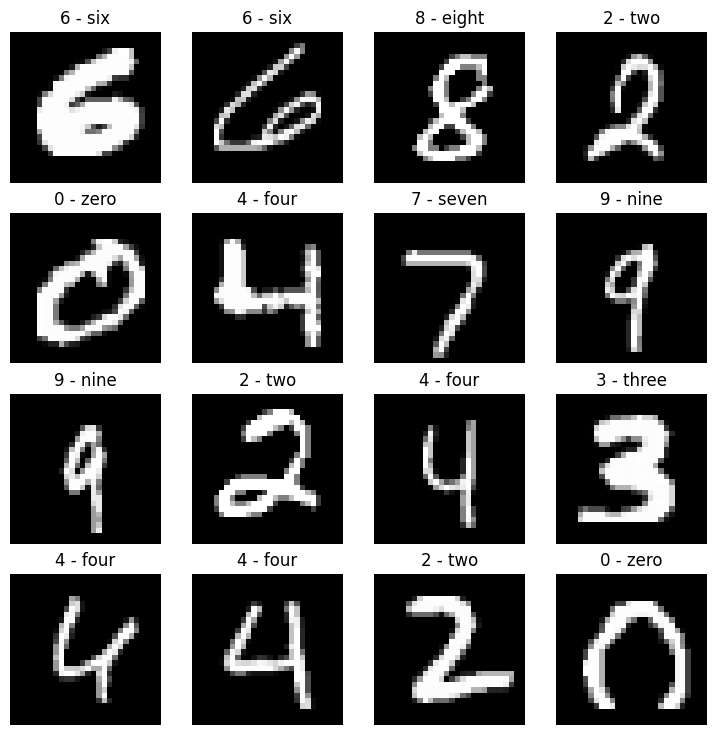

In [4]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [5]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [6]:
class CNNNum(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(
                hidden_units,
                hidden_units,
                3,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                hidden_units,
                hidden_units,
                3,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )
    
    def forward(self, x : torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

model = CNNNum(1, 10, len(class_names)).to(device)
model

CNNNum(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_data = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_data = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [9]:
def train_step(
    model: torch.nn.Module,
    data_loader : torch.utils.data.DataLoader,
    loss_fn : torch.nn.Module,
    optimizer : torch.optim.Optimizer,
    accuracy_fn,
    device : torch.device = device):

    model.train()
    train_loss, train_acc = 0,0
    model.to(device)
    for batch, (X,y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(
    data_loader : torch.utils.data.DataLoader,
    model : torch.nn.Module,
    loss_fn : torch.nn.Module,
    accuracy_fn,
    device : torch.device = device):

    test_loss, test_acc = 0,0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [10]:
from helper_functions import accuracy_fn

epochs = 5
for epoch in tqdm(range(epochs)):
    train_step(data_loader=train_data, model=model, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn)
    test_step(
        data_loader=test_data,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.46579 | Train accuracy: 83.45%


 20%|██        | 1/5 [00:08<00:35,  8.76s/it]

Test loss: 0.08611 | Test accuracy: 97.23%

Train loss: 0.07781 | Train accuracy: 97.54%


 40%|████      | 2/5 [00:16<00:24,  8.27s/it]

Test loss: 0.05016 | Test accuracy: 98.44%

Train loss: 0.06027 | Train accuracy: 98.14%


 60%|██████    | 3/5 [00:24<00:16,  8.12s/it]

Test loss: 0.04875 | Test accuracy: 98.36%

Train loss: 0.05128 | Train accuracy: 98.39%


 80%|████████  | 4/5 [00:32<00:08,  8.05s/it]

Test loss: 0.04666 | Test accuracy: 98.58%

Train loss: 0.04569 | Train accuracy: 98.55%


100%|██████████| 5/5 [00:40<00:00,  8.10s/it]

Test loss: 0.04853 | Test accuracy: 98.49%

